In [1]:
import networkx as nx
import numpy as np; np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from simulate import ODE_simulate, GILL_simulate
from plot_module import plot_ODE, plot_gillespie, plot_network
from sim_param_from_network import names_from_network, gillespie_reaction_dict_from_network, dataframes_from_network, ODE_from_network
from network_generate import linear_network

import libgillespie

In [2]:
MAX_T = 10000
TIME_POINTS = np.linspace(0, MAX_T, 1001)

## Define network topology and numeric parameters

In [3]:
# G = nx.DiGraph()

# G.add_node('N1', birth_type=2, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('N2', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('N3', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('N4', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('N5', birth_type=1, c_b = 0.1, birth_rate = 0.07, nss=200, delta = 0.5, death_rate = 0.07,)

# G.add_edge('N1', 'N2', rate=0.15)
# G.add_edge('N2', 'N3', rate=0.15)
# G.add_edge('N3', 'N4', rate=0.15)
# G.add_edge('N4', 'N5', rate=0.15)
# G.add_edge('N5', 'N1', rate=0.15)

# plot_network(G)
# VARS, COMP = names_from_network(G)

# # set a given starting state
# start_state = [190, 20, 190, 20, 190, 20, 190, 20, 190, 20]

In [4]:
# G = nx.DiGraph()

# G.add_node('Soma', birth_type=2, c_b = 0.1, birth_rate = 0.14, nss=200, delta = 0.5, death_rate = 0.07,)
# G.add_node('Axon', birth_type=0, c_b = 0.1, birth_rate = 0.00, nss=200, delta = 0.5, death_rate = 0.07,)

# G.add_edge('Soma', 'Axon', rate=0.14)
# G.add_edge('Axon', 'Soma', rate=0.07)

# plot_network(G)
# VARS, COMP = names_from_network(G)

# # set a given starting state
# start_state = [190, 20, 190, 20]

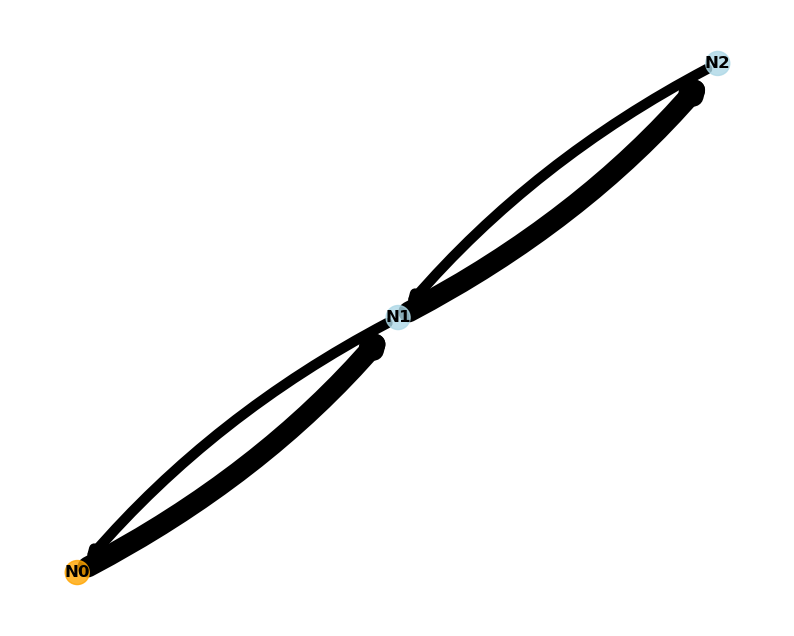

In [5]:
bio_param = {'c_b' : 0.1, 'mu_a' : 0.07, 'nss' : 100, 'delta' : 0.5, 'mu' : 0.03,'gamma_ant':0.30, 'gamma_ret':0.15}
G, VARS, COMP, start_state = linear_network(3, bio_param, start_pop = [9, 1])
plot_network(G)

## Get ODE representation of network, and run simulation

In [6]:
ODE_model = ODE_from_network(G)

> Code for ODE model:

global ODE_model
def ODE_model(t, z):
	# variables (node name + wt/mt)
	N0_wt, N0_mt, N1_wt, N1_mt, N2_wt, N2_mt = z
	return [
		# ΔN0_wt/Δt
		(N0_wt*((0.07 + 0.1*(100-N0_wt-(0.5*N0_mt)))-(0.03)-(0.3)))+(N1_wt*0.15),
		# ΔN0_mt/Δt
		(N0_mt*((0.07 + 0.1*(100-N0_wt-(0.5*N0_mt)))-(0.03)-(0.3)))+(N1_mt*0.15),
		# ΔN1_wt/Δt
		(N1_wt*(0-(0.03)-(0.45)))+(N0_wt*0.3)+(N2_wt*0.15),
		# ΔN1_mt/Δt
		(N1_mt*(0-(0.03)-(0.45)))+(N0_mt*0.3)+(N2_mt*0.15),
		# ΔN2_wt/Δt
		(N2_wt*(0-(0.03)-(0.15)))+(N1_wt*0.3),
		# ΔN2_mt/Δt
		(N2_mt*(0-(0.03)-(0.15)))+(N1_mt*0.3),
		]


> Final counts of mt and wt in each compartment:
N0_wt	94.1272	
N0_mt	10.4586	
N1_wt	122.7746	
N1_mt	13.6416	
N2_wt	204.6244	
N2_mt	22.736	

> Final effective population sizes in each compartment:
N0	99.3565	
N1	129.5955	
N2	215.9924	


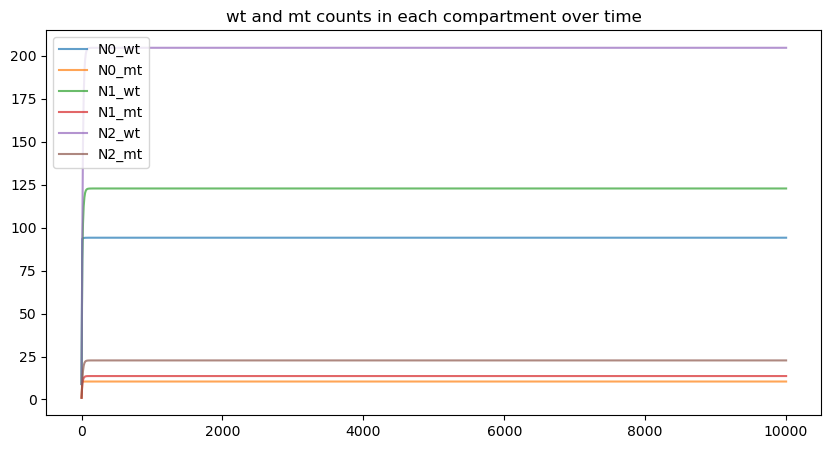

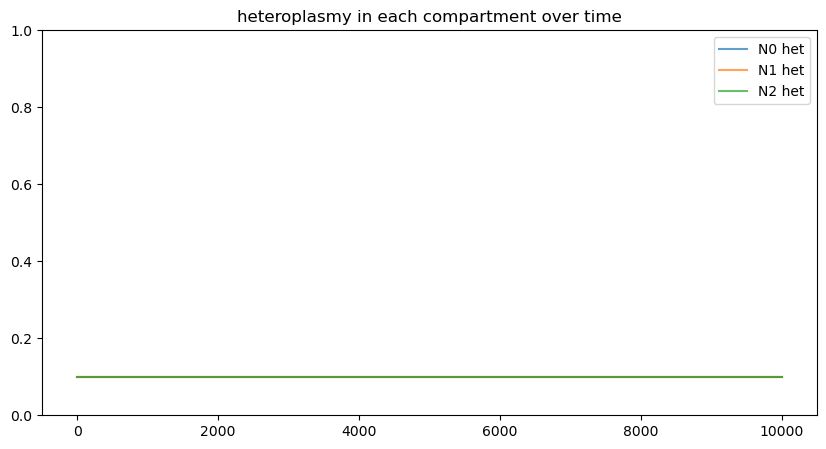

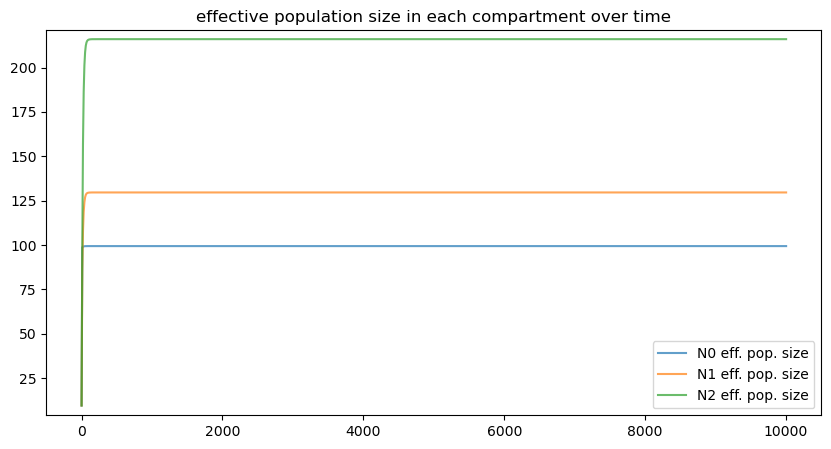

In [7]:
ode_results = ODE_simulate(ODE_model, TIME_POINTS, start_state)
plot_ODE(ode_results, TIME_POINTS, 0.5, VARS, COMP)

## Get gillespie simulation for network

In [8]:
gill_param = gillespie_reaction_dict_from_network(G)

> Reactions:
react.#	state i	type	rate	update to system
0	0	birth	-1	[1, 0, 0, 0, 0, 0]
1	1	birth	-1	[0, 1, 0, 0, 0, 0]
2	0	death	0.03	[-1, 0, 0, 0, 0, 0]
3	1	death	0.03	[0, -1, 0, 0, 0, 0]
4	2	death	0.03	[0, 0, -1, 0, 0, 0]
5	3	death	0.03	[0, 0, 0, -1, 0, 0]
6	4	death	0.03	[0, 0, 0, 0, -1, 0]
7	5	death	0.03	[0, 0, 0, 0, 0, -1]
8	0	trnspt	0.3	[-1, 0, 1, 0, 0, 0]
9	1	trnspt	0.3	[0, -1, 0, 1, 0, 0]
10	2	trnspt	0.15	[1, 0, -1, 0, 0, 0]
11	3	trnspt	0.15	[0, 1, 0, -1, 0, 0]
12	2	trnspt	0.3	[0, 0, -1, 0, 1, 0]
13	3	trnspt	0.3	[0, 0, 0, -1, 0, 1]
14	4	trnspt	0.15	[0, 0, 1, 0, -1, 0]
15	5	trnspt	0.15	[0, 0, 0, 1, 0, -1]

> Dynamic birth rates:
react.#	state i	par(c_b, mu, nss, delta)
0, 1	0	[0.1, 0.07, 100.0, 0.5]


In [9]:
time_points = np.array(TIME_POINTS, dtype = np.float64)
react_rates = np.array(gill_param['gillespie']['reaction_rates'], dtype=np.float64)
state_index = np.array(gill_param['gillespie']['state_index'], dtype=np.int64)
sys_state   = np.array([9,1,9,1,9,1], dtype=np.int64)
n_pops      = 12
n_reactions = 16
sys_state_sample = np.zeros((len(start_state), time_points.size), dtype = np.int64, order = 'F')
reactions = np.array(gill_param['gillespie']['reactions'], dtype=np.int64, order = 'F')
birth_update_par = np.array([0.1, 0.07, 100.0, 0.5], dtype = np.float64)

In [10]:
# arg0: numpy.ndarray[numpy.float64], 
# arg1: numpy.ndarray[numpy.float64], 
# arg2: numpy.ndarray[numpy.int64], 
# arg3: numpy.ndarray[numpy.int64], 
# arg4: int, 
# arg5: int, 
# arg6: numpy.ndarray[numpy.int64[m, n], flags.writeable, flags.f_contiguous], 
# arg7: numpy.ndarray[numpy.int64[m, n], flags.writeable, flags.f_contiguous], 
# arg8: numpy.ndarray[numpy.float64]

In [ ]:
try:
    libgillespie.simulate(time_points, react_rates, state_index, sys_state, n_pops, n_reactions, sys_state_sample, reactions, birth_update_par)
except RuntimeError as e:
    print(f"C++ error: {e}")

In [ ]:
#gill_results = GILL_simulate(gill_param, TIME_POINTS, start_state, replicates=100, onedynamic = True)

In [ ]:
# def get_result_statistics(
#         replicate_results,  # variable values over time (number of wildtype and mutant in each compartment)
#         time_points,        # time points where system is sampled
#         delta,              # mutant deficiency, used in calculating effective population sizes
#         vari,               # name of the variables being tracked (compartment name + wt/mt)
#         comp                # name of the compartments (e.g. soma, axon, etc.)
#         ):
    
#     n_vars = len(vari)
#     n_comp = len(comp)
    
#     # separate out wt and mt counts per compartment
#     wt_counts = replicate_results[:,np.arange(0, n_vars, 2),:]
#     mt_counts = replicate_results[:,np.arange(1, n_vars, 2),:]
    
#     # get the number of wt and mt in the full system (summed over compartments)
#     wt_totals = np.sum(wt_counts, axis = 1)
#     mt_totals = np.sum(mt_counts, axis = 1)    

#     # get mean counts of each variable over time
#     mean_var_value = np.mean(replicate_results, axis=0)

#     # get the mean heteroplasmy of each compartment
#     mean_per_comp_het= np.mean(mt_counts/(wt_counts+mt_counts), axis = 0)
    
#     # get the mean effective population size of each compartment
#     mean_per_comp_het= np.mean(mt_counts*delta + wt_counts, axis = 0)
    
#     # get the total heteroplasmies of all the replicatse
#     total_het = mt_totals/(wt_totals+mt_totals)
    
#     # get the total heteroplasmies in the last time point
#     final_total_het = total_het[:,-1]
    
#     print(final_total_het)
    
    
# get_result_statistics(gill_results, TIME_POINTS, 0.5, VARS, COMP)

In [ ]:
#plot_gillespie(gill_results, TIME_POINTS, 0.5, VARS, COMP)